In [2]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils_gen_NN import gen_density_map_gaussian_torch
import matplotlib.pyplot as plt
%matplotlib inline


root = '/Users/soumyadip_iitk/Desktop/Dense Crowd Model/Sanghai_Data'
part_A_train = os.path.join(root, 'part_A/train_data', 'images')
part_A_test = os.path.join(root, 'part_A/test_data', 'images')
part_B_train = os.path.join(root, 'part_B/train_data', 'images')
part_B_test = os.path.join(root, 'part_B/test_data', 'images')
path_sets_A = [part_A_train, part_A_test]
path_sets_B = [part_B_train, part_B_test]
img_paths_A = []
for path in path_sets_A:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_A.append(img_path)
print(len(img_paths_A))
img_paths_B = []
for path in path_sets_B:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_B.append(img_path)
print(len(img_paths_B))

482
716


In [4]:
import torch
import cv2
import numpy as np
import h5py
import os
from scipy.io import loadmat
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for dataset in ['A']:
    img_paths = eval('img_paths_'+dataset)
    for img_path in tqdm(img_paths):
        # Load image and ground truth
        img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
        img = cv2.imread(img_path)
        
        # Set sigma based on dataset part
        sigma = 4 if 'part_A' in img_path else 15
        
        # Extract ground truth points
        gt = pts["image_info"][0, 0][0, 0][0]
        
        # Validate and filter points within image bounds
        valid_points = []
        for i in range(len(gt)):
            x, y = int(gt[i][0]), int(gt[i][1])
            if y < img.shape[0] and x < img.shape[1]:
                valid_points.append([x, y])  # Note: x,y format for consistency
        
        # Convert to numpy array
        if len(valid_points) > 0:
            points = np.array(valid_points)
        else:
            points = np.array([]).reshape(0, 2)
        
        # Generate density map using PyTorch function
        DM = gen_density_map_gaussian_torch(
            im_shape=(img.shape[0], img.shape[1]), 
            points=points, 
            sigma=sigma, 
            device=device
        )
        
        # Create file path and ensure directory exists
        file_path = img_path.replace('.jpg', '.h5').replace('images', 'ground')
        directory = os.path.dirname(file_path)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
        
        # Save density map to h5 file
        with h5py.File(file_path, 'w') as hf:
            hf['density'] = DM.cpu().numpy()  # Convert back to numpy for saving

100%|██████████| 482/482 [00:15<00:00, 30.24it/s]


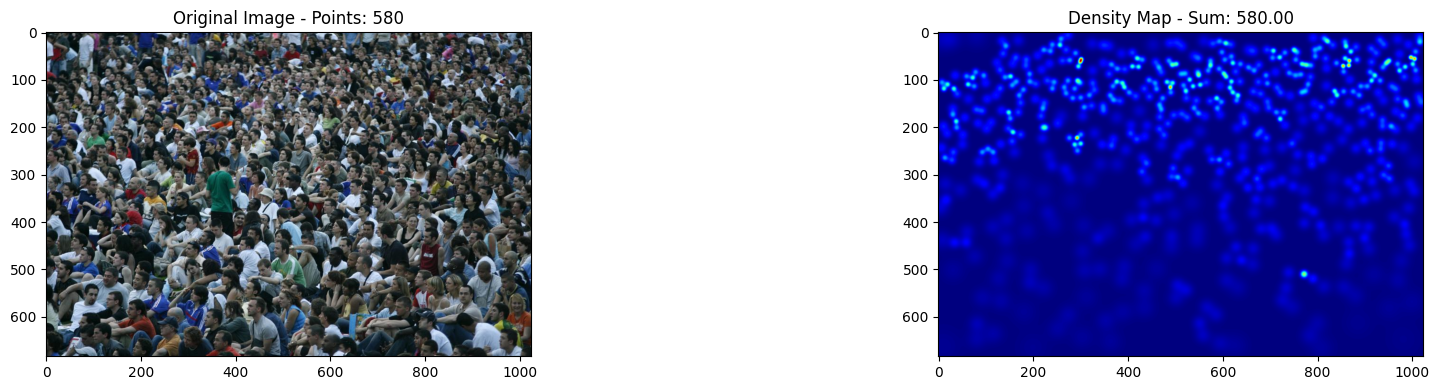

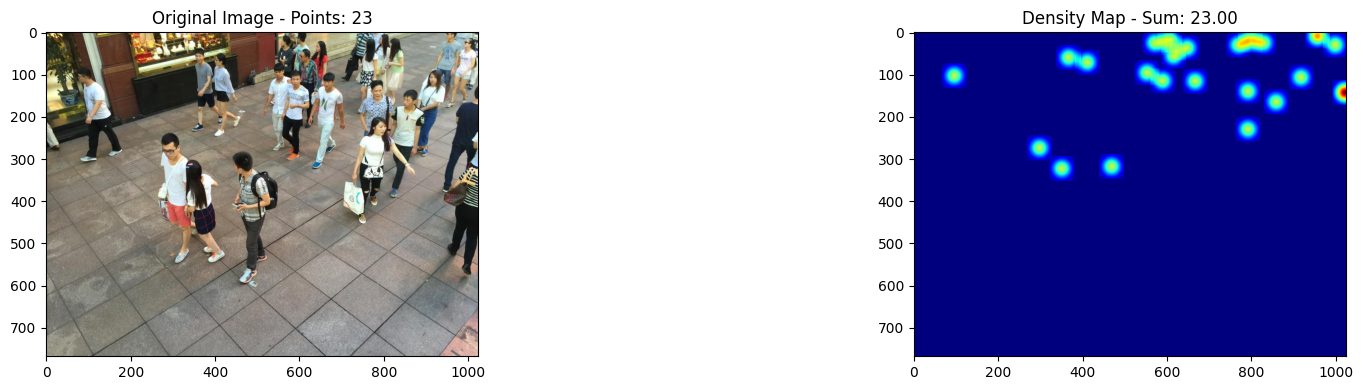

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img_paths = ['/Users/soumyadip_iitk/Desktop/Dense Crowd Model/Sanghai_Data/part_A/train_data/images/IMG_196.jpg',
             '/Users/soumyadip_iitk/Desktop/Dense Crowd Model/Sanghai_Data/part_B/test_data/images/IMG_1.jpg']

for img_path in img_paths:
    # Load image and ground truth
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)
    
    # Set sigma based on dataset part
    sigma = 4 if 'part_A' in img_path else 15
    
    # Extract ground truth points
    gt = pts["image_info"][0, 0][0, 0][0]
    
    # Validate and filter points within image bounds
    valid_points = []
    for i in range(len(gt)):
        x, y = int(gt[i][0]), int(gt[i][1])
        if y < img.shape[0] and x < img.shape[1]:
            valid_points.append([x, y])  # [x, y] format for consistency
    
    # Convert to numpy array
    if len(valid_points) > 0:
        points = np.array(valid_points)
    else:
        points = np.array([]).reshape(0, 2)
    
    # Generate density map using updated PyTorch function
    DM = gen_density_map_gaussian_torch(
        im_shape=(img.shape[0], img.shape[1]), 
        points=points, 
        sigma=sigma, 
        device=device
    )
    
    # Convert tensor to numpy for visualization
    DM_numpy = DM.cpu().numpy()
    
    # Visualization
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(f'Original Image - Points: {len(valid_points)}')
    ax1.imshow(np.squeeze(DM_numpy), cmap=plt.cm.jet)
    ax1.set_title(f'Density Map - Sum: {np.sum(DM_numpy):.2f}')
    plt.tight_layout()
    plt.show()
